<a href="https://colab.research.google.com/github/chaewoncutie/ADV-ML-tests/blob/main/looking_for_the_best_parameters_in_TF_IDF_and_UMAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
# Install necessary packages
!pip install -U scikit-learn nltk pandas matplotlib seaborn scipy wordcloud ipywidgets umap-learn

In [35]:
# Import necessary libraries
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, adjusted_rand_score, normalized_mutual_info_score, accuracy_score, precision_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from wordcloud import WordCloud
import numpy as np
import umap
from google.colab import files
from sklearn.metrics.pairwise import cosine_similarity

In [36]:
# Download stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [37]:
# Upload the JSON file
uploaded = files.upload()

# Read the JSON file
df = pd.read_json(next(iter(uploaded)), lines=True)
df = df[['headline', 'short_description']].dropna()
df['text'] = df['headline'] + " " + df['short_description']

df.head()

Saving News_Category_Dataset_v3.json to News_Category_Dataset_v3 (1).json


,headline,short_description,text
0,Over 4 Million Americans Roll Up Sleeves For O...,Health experts said it is too early to predict...,Over 4 Million Americans Roll Up Sleeves For O...
1,"American Airlines Flyer Charged, Banned For Li...",He was subdued by passengers and crew when he ...,"American Airlines Flyer Charged, Banned For Li..."
2,23 Of The Funniest Tweets About Cats And Dogs ...,"""Until you have a dog you don't understand wha...",23 Of The Funniest Tweets About Cats And Dogs ...
3,The Funniest Tweets From Parents This Week (Se...,"""Accidentally put grown-up toothpaste on my to...",The Funniest Tweets From Parents This Week (Se...
4,Woman Who Called Cops On Black Bird-Watcher Lo...,Amy Cooper accused investment firm Franklin Te...,Woman Who Called Cops On Black Bird-Watcher Lo...


In [38]:
# Limit dataset size for faster processing
df = df.sample(n=50000, random_state=42)

# Preprocessing Function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation & numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df['processed_text'] = df['text'].apply(preprocess_text)

In [39]:
# Tokenize, remove stopwords, and apply lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text) if word not in stop_words])

df['filtered_text'] = df['processed_text'].apply(tokenize_and_lemmatize)

In [40]:
# TF-IDF Vectorization with parameter looping
best_explained_variance = 0
best_vectorizer_params = {}

for max_df in [0.7, 0.8, 0.9]:
    for min_df in [5, 10, 20]:
        for ngram_range in [(1,1), (1,2)]:
            vectorizer = TfidfVectorizer(max_features=3000, stop_words='english', ngram_range=ngram_range, max_df=max_df, min_df=min_df)
            X = vectorizer.fit_transform(df['filtered_text'])
            explained_variance = np.sum(TruncatedSVD(n_components=50, random_state=42).fit(X).explained_variance_ratio_)

            if explained_variance > best_explained_variance:
                best_explained_variance = explained_variance
                best_vectorizer_params = {'max_df': max_df, 'min_df': min_df, 'ngram_range': ngram_range}

print(f'Best TF-IDF Parameters: {best_vectorizer_params}')
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', **best_vectorizer_params)
X = vectorizer.fit_transform(df['filtered_text'])

Best TF-IDF Parameters: {'max_df': 0.7, 'min_df': 5, 'ngram_range': (1, 2)}


In [42]:
# ----------------- SVD COMPONENT SELECTION -----------------
n_components_range = range(10, 101, 10)
explained_variance = []

for n in n_components_range:
    svd = TruncatedSVD(n_components=n, random_state=42)
    X_svd_temp = svd.fit_transform(X)
    explained_variance.append(svd.explained_variance_ratio_.sum())
    print(f'n_components={n}, explained variance={svd.explained_variance_ratio_.sum():.4f}')

# If no component reaches 0.90 explained variance, use the maximum
try:
    best_n_components = next(n for n, ev in zip(n_components_range, explained_variance) if ev >= 0.90)
except StopIteration:
    best_n_components = n_components_range[-1]  # Use the last/highest n_components

print(f'Selected n_components for SVD: {best_n_components}')
svd = TruncatedSVD(n_components=best_n_components, random_state=42)
X_svd = svd.fit_transform(X)


n_components=10, explained variance=0.0246
n_components=20, explained variance=0.0427
n_components=30, explained variance=0.0583
n_components=40, explained variance=0.0719
n_components=50, explained variance=0.0843
n_components=60, explained variance=0.0958
n_components=70, explained variance=0.1061
n_components=80, explained variance=0.1161
n_components=90, explained variance=0.1254
n_components=100, explained variance=0.1342
Selected n_components for SVD: 100


In [43]:
# UMAP parameter looping
best_umap_score = -1
best_umap_params = {}

for n_neighbors in [10, 30, 50]:
    for min_dist in [0.1, 0.3, 0.5]:
        umap_model = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
        X_umap_temp = umap_model.fit_transform(X_svd)
        silhouette = silhouette_score(X_umap_temp, KMeans(n_clusters=12, random_state=42).fit_predict(X_umap_temp))

        if silhouette > best_umap_score:
            best_umap_score = silhouette
            best_umap_params = {'n_neighbors': n_neighbors, 'min_dist': min_dist}

print(f'Best UMAP Parameters: {best_umap_params}')
umap_model = umap.UMAP(n_components=2, **best_umap_params, random_state=42)
X_umap = umap_model.fit_transform(X_svd)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs val

Best UMAP Parameters: {'n_neighbors': 50, 'min_dist': 0.1}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


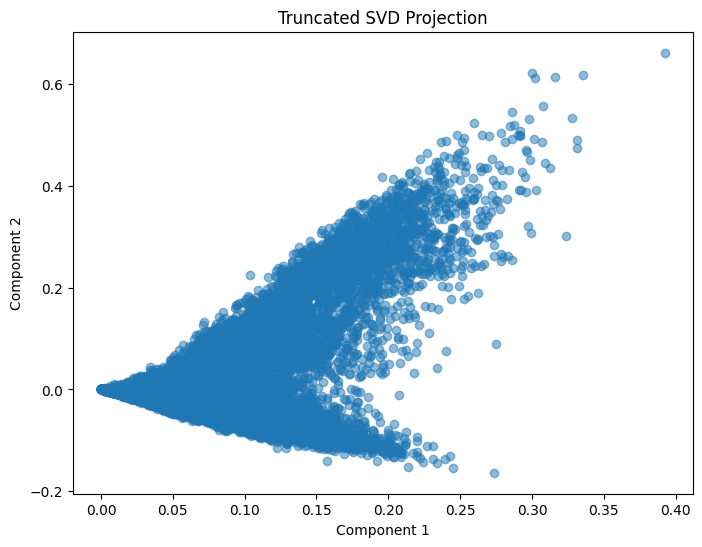

In [44]:
# Plot Truncated SVD
plt.figure(figsize=(8, 6))
plt.scatter(X_svd[:, 0], X_svd[:, 1], alpha=0.5)
plt.title('Truncated SVD Projection')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

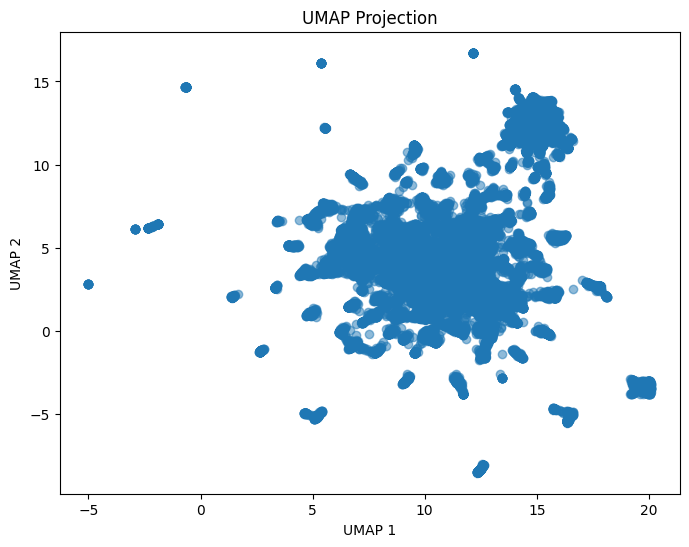

In [45]:
# Plot UMAP Projection
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], alpha=0.5)
plt.title('UMAP Projection')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [46]:
# Normalize data
normalizer = Normalizer()
X_normalized = normalizer.fit_transform(X_umap)

In [47]:
# ----------------- CLUSTERING AND EVALUATION -----------------
kmeans_final = KMeans(n_clusters=12, random_state=42, n_init=50)
df['kmeans_cluster'] = kmeans_final.fit_predict(X_normalized)

gmm = GaussianMixture(n_components=12, covariance_type='full', random_state=42)
df['gmm_cluster'] = gmm.fit_predict(X_normalized)

ari_kmeans = adjusted_rand_score(df['kmeans_cluster'], df['gmm_cluster'])
nmi_kmeans = normalized_mutual_info_score(df['kmeans_cluster'], df['gmm_cluster'])
accuracy = accuracy_score(df['kmeans_cluster'], df['gmm_cluster'])
precision = precision_score(df['kmeans_cluster'], df['gmm_cluster'], average='weighted')

print(f'ARI: {ari_kmeans:.4f}, NMI: {nmi_kmeans:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}')


ARI: 0.6721, NMI: 0.8389, Accuracy: 0.1430, Precision: 0.1373
